In [1]:
#Partially adopted from Tensorflow/docs/basic_text_classification
#https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/basic_text_classification.ipynb

#As well as https://developers.google.com/machine-learning/guides/text-classification/

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

import numpy as np

print(tf.__version__)

import nltk
nltk.download('punkt')
from nltk import word_tokenize
stemmer = nltk.stem.SnowballStemmer('english')

Using TensorFlow backend.


1.11.0
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
#MAPPING SENTENCES TO LIBRARY
import json

#declare trainData as an empty list
trainData = []
trainLabels = []
    
#temp list for each sentence
tempList = []

#Keeping track of used sentences
used = []

#Keeping track of used requirement statements
accessControl = []
databaseDesign = []
privacy = []
security = []


#this is the smallest number of unique non-functional requirements of a single class
LIMIT = 208

#library a.k.a. bag of words
with open("Consolidated_data.txt","r") as f, open("libraryStemmed.json", "r") as l:
    data = json.load(l)

    #Go line by line in original data file
    for line in f:
        #find where class begins
        front = line.find("\"class\":\"")
        #find where class ends (where sentence begins)
        end = line.find("\",\"sentence\":\"")
        #substring line based on front and end above
        reqClass = (line[(front+9):end]).lower()

        #sentence
        del tempList[:]
        temp = line.find("\"sentence\":\"")
        sentence = (line[(temp+12):-4]).lower()
        sentence = sentence.translate(None, '.,-\":;~!@#$%^&?[]{}<>`1234567890\\*()').strip()
        
        if "access control" in reqClass and (len(accessControl) < LIMIT):
            if sentence in used:
                continue
            used.append(sentence)
            trainLabels.append(0)
            accessControl.append(sentence)
            for x in sentence.split(' '):
                x = unicode(x, 'utf-8')
                x = stemmer.stem(x)
                if x in data:
                    tempList.append(data[x])
                else:
                    tempList.append(1)
            trainData.append(tempList[:])
        elif "database design" in reqClass and (len(databaseDesign) < LIMIT):
            if sentence in used:
                continue
            used.append(sentence)
            databaseDesign.append(sentence)
            trainLabels.append(1)
            for x in sentence.split(' '):
                x = unicode(x, 'utf-8')
                x = stemmer.stem(x)
                if x in data:
                    tempList.append(data[x])
                else:
                    tempList.append(1)
            trainData.append(tempList[:])
        elif "privacy" in reqClass and (len(privacy) < LIMIT):
            if sentence in used:
                continue
            used.append(sentence)
            privacy.append(sentence)
            trainLabels.append(2)
            for x in sentence.split(' '):
                x = unicode(x, 'utf-8')
                x = stemmer.stem(x)
                if x in data:
                    tempList.append(data[x])
                else:
                    tempList.append(1)
            trainData.append(tempList[:])
        elif "security" in reqClass and (len(security) < LIMIT):
            if sentence in used:
                continue
            used.append(sentence)
            security.append(sentence)
            trainLabels.append(3)
            for x in sentence.split(' '):
                x = unicode(x, 'utf-8')
                x = stemmer.stem(x)
                if x in data:
                    tempList.append(data[x])
                else:
                    tempList.append(1)
            trainData.append(tempList[:])


In [4]:
#Must all be balanced for valid results.
#Commented out the total number of sentences in the document.
print len(accessControl) #464
print len(databaseDesign) #852
print len(privacy) #208
print len(security) #270

208
208
208
208


In [5]:
#Shuffle is necessary to randomize the data in the array.
#Correspondence with labels is saved
used, trainLabels = shuffle(used, trainLabels)

#total sentences = 208*4
#split is how many sentences are used for training
split = 732
#testSplit is how many sentences are used for testing
testSplit = 100

validation = used[split:]
train = used[:split]
validationLabels = trainLabels[split:]
trainLabels = trainLabels[:split]

test = train[:testSplit]
train = train[testSplit:]
testLabels = trainLabels[:testSplit]
trainLabels = trainLabels[testSplit:]

test, testLabels = shuffle(test, testLabels)
validation, validationLabels = shuffle(validation, validationLabels)
train, trainLabels = shuffle(train, trainLabels)

print("Test set length: ", len(test))
print("Test labels set length: ", len(testLabels))
print("Validation set length: ", len(validation))
print("Validation labels set length: ", len(validationLabels))
print("Train set length: ", len(train))
print("Train labels set length: ", len(trainLabels))

('Test set length: ', 100)
('Test labels set length: ', 100)
('Validation set length: ', 100)
('Validation labels set length: ', 100)
('Train set length: ', 632)
('Train labels set length: ', 632)


In [6]:
def ngram_vectorize(train_texts, train_labels, val_texts, test_texts):
    
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': (1,3),  # Use 1-grams + 2-grams + 3-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
            'min_df': 3, #Words that appear less than this value do not contribute
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)
    
    # Vectorize test texts.
    x_test = vectorizer.transform(test_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(4000, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    x_test = selector.transform(x_test).astype('float32')
    return x_train, x_val, x_test

In [7]:
trainData, valData, testData = ngram_vectorize(train, trainLabels, validation, test)

/usr/local/lib/python2.7/dist-packages/sklearn/feature_extraction/text.py:1547: UserWarning: Only (<type 'numpy.float64'>, <type 'numpy.float32'>, <type 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


In [8]:
#Constructing the model method
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    model = keras.Sequential()
    model.add(keras.layers.Dropout(rate=dropout_rate, input_shape=input_shape))
    for _ in range(layers-1):
        model.add(keras.layers.Dense(units=units, activation=tf.nn.relu))
        model.add(keras.layers.Dropout(rate=dropout_rate))

    model.add(keras.layers.Dense(units=num_classes, activation=tf.nn.softmax))
    return model

In [9]:
#For parameters refer to the upper cell
model = mlp_model(2, 64, 0.3, trainData.shape[1:], 4)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 2192)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                140352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 140,612
Trainable params: 140,612
Non-trainable params: 0
_________________________________________________________________


In [10]:
#Learning rate could be further decreased for additional accuracy
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.0003),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
#callbacks will prevent model from running if val_loss starts to increase
callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

history = model.fit(trainData,
                    trainLabels,
                    epochs=500,
                    callbacks = callbacks,
                    batch_size=128,
                    validation_data=(valData, validationLabels),
                    verbose=2)

Train on 632 samples, validate on 100 samples
Epoch 1/500
 - 1s - loss: 1.3836 - acc: 0.2769 - val_loss: 1.3811 - val_acc: 0.3500
Epoch 2/500
 - 0s - loss: 1.3735 - acc: 0.4035 - val_loss: 1.3740 - val_acc: 0.4700
Epoch 3/500
 - 0s - loss: 1.3660 - acc: 0.4652 - val_loss: 1.3666 - val_acc: 0.5400
Epoch 4/500
 - 0s - loss: 1.3540 - acc: 0.5649 - val_loss: 1.3588 - val_acc: 0.5700
Epoch 5/500
 - 0s - loss: 1.3470 - acc: 0.5870 - val_loss: 1.3500 - val_acc: 0.5600
Epoch 6/500
 - 0s - loss: 1.3364 - acc: 0.6171 - val_loss: 1.3404 - val_acc: 0.5900
Epoch 7/500
 - 0s - loss: 1.3223 - acc: 0.6709 - val_loss: 1.3300 - val_acc: 0.6000
Epoch 8/500
 - 0s - loss: 1.3088 - acc: 0.6946 - val_loss: 1.3185 - val_acc: 0.6200
Epoch 9/500
 - 0s - loss: 1.2930 - acc: 0.7373 - val_loss: 1.3062 - val_acc: 0.6400
Epoch 10/500
 - 0s - loss: 1.2800 - acc: 0.7326 - val_loss: 1.2927 - val_acc: 0.6700
Epoch 11/500
 - 0s - loss: 1.2624 - acc: 0.7468 - val_loss: 1.2786 - val_acc: 0.6800
Epoch 12/500
 - 0s - loss: 1

Epoch 97/500
 - 0s - loss: 0.2851 - acc: 0.9541 - val_loss: 0.5156 - val_acc: 0.8300
Epoch 98/500
 - 0s - loss: 0.2833 - acc: 0.9573 - val_loss: 0.5133 - val_acc: 0.8300
Epoch 99/500
 - 0s - loss: 0.2810 - acc: 0.9509 - val_loss: 0.5111 - val_acc: 0.8300
Epoch 100/500
 - 0s - loss: 0.2652 - acc: 0.9715 - val_loss: 0.5090 - val_acc: 0.8300
Epoch 101/500
 - 0s - loss: 0.2578 - acc: 0.9699 - val_loss: 0.5069 - val_acc: 0.8300
Epoch 102/500
 - 0s - loss: 0.2658 - acc: 0.9573 - val_loss: 0.5050 - val_acc: 0.8300
Epoch 103/500
 - 0s - loss: 0.2616 - acc: 0.9462 - val_loss: 0.5031 - val_acc: 0.8300
Epoch 104/500
 - 0s - loss: 0.2695 - acc: 0.9494 - val_loss: 0.5013 - val_acc: 0.8300
Epoch 105/500
 - 0s - loss: 0.2553 - acc: 0.9699 - val_loss: 0.4996 - val_acc: 0.8300
Epoch 106/500
 - 0s - loss: 0.2536 - acc: 0.9636 - val_loss: 0.4978 - val_acc: 0.8300
Epoch 107/500
 - 0s - loss: 0.2519 - acc: 0.9541 - val_loss: 0.4962 - val_acc: 0.8300
Epoch 108/500
 - 0s - loss: 0.2437 - acc: 0.9668 - val_lo

In [12]:
#Evalueating model on the testset
#[loss, accuracy]
print(model.evaluate(testData, testLabels))

100/100 [==============================] - 0s 222us/step
[0.4705450946092606, 0.87]


In [13]:
#The rest of the notebook helps vidualize losses and accuracies by ploting two separate grophs
history_dict = history.history
history_dict.keys()

['acc', 'loss', 'val_acc', 'val_loss']

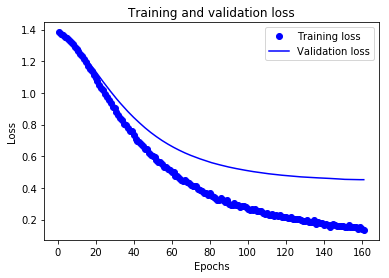

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

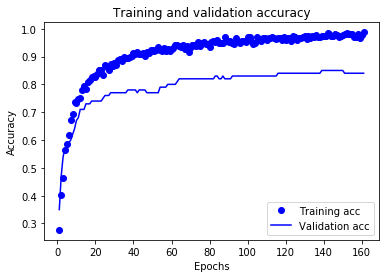

In [15]:
plt.clf() #clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()